In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('omw-1.4')
from nltk import FreqDist
import string
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences,to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Embedding,SpatialDropout1D,Bidirectional,Dropout
import demoji
from textblob import TextBlob
from wordcloud import WordCloud
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

df = pd.read_csv("C:/ML/python/data/amazon_reviews.csv",delimiter=',')

df.head(10)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,414d59b0-dbdd-43fe-b655-1f85bf8fd329,Adrian-Victor,Doesn't do anything more than the website.,1,0,NaN,2024-06-18 21:20:30,NaN
1,ed502bcb-0881-4db6-a02d-8250b69eefba,Nukeman25Gaming,They should make it so with teens that have Am...,5,0,28.12.0.100,2024-06-18 21:12:11,28.12.0.100
2,881eca25-3727-44c7-8939-d101d7d27a1d,phillip “The Mule”,"Could not find ""Log Out"" dumped the app",1,0,24.18.2.100,2024-06-18 21:05:11,24.18.2.100
3,6640b687-a5d0-4ef3-a1c9-d07d89ca6007,Taylor Nowitzke,They lie about shipping times and give no info...,1,0,28.12.0.100,2024-06-18 20:33:28,28.12.0.100
4,cfa3d0fb-8544-44bf-8c31-ad89cf3693d8,Zaylen Nordick,"Not only is the UI garbage, it can tale your m...",1,0,28.12.0.100,2024-06-18 20:31:42,28.12.0.100
5,b2136973-1df4-4ffe-8195-c1fb4ea60399,Lorna Slaughter,Excellent,5,0,28.11.2.100,2024-06-18 20:18:43,28.11.2.100
6,7c742cdb-021a-45e4-b2a6-6f3a0d98b677,Chit Chat Lobby,jeff bezozs can pay me million euros to change...,1,0,28.12.0.100,2024-06-18 20:09:50,28.12.0.100
7,67e76f86-ebe3-49ac-801f-00124bd3d7a4,Patricia Jones,Great 👍 app,5,0,28.10.0.100,2024-06-18 19:52:53,28.10.0.100
8,6ed10d03-c16b-4822-a7f9-9abe45614c77,ezridr1234,BEWARE!! AMAZON HAS BEEN ALLOWING THEFT OF MY ...,1,1,28.11.2.100,2024-06-18 19:42:57,28.11.2.100
9,c199fdf5-9fa0-4bd7-aac5-2cc4441d2d11,Cory Johnson,"They've implemented an ""AI"" chat feature and l...",2,3,28.12.0.100,2024-06-18 19:27:35,28.12.0.100


In [3]:
df.drop(['reviewId', 'userName', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],axis=1,inplace=True)



df.isnull().sum()


content    2
dtype: int64

In [4]:
df['content'] = df['content'].fillna("")
df.duplicated().sum()

np.int64(398)

In [5]:
df.drop_duplicates(inplace=True)

#### lower-casing and cleaning text

def clean_text(text):
    
    text = str(text).lower()

    text = re.sub(r'<.*?>', '',text)
    
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    text = demoji.replace(text,'')
    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    
    return text

df['content'] = df['content'].apply(clean_text)
df['content'].head(10)



0             doesnt do anything more than the website
1    they should make it so with teens that have am...
2                could not find log out dumped the app
3    they lie about shipping times and give no info...
4    not only is the ui garbage it can tale your mo...
5                                            excellent
6    jeff bezozs can pay me million euros to change...
7                                           great  app
8    beware amazon has been allowing theft of my ac...
9    theyve implemented an ai chat feature and like...
Name: content, dtype: object

In [6]:
### stopwords for text cleaning
sw = set(stopwords.words("english"))


def remove_stopwords(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word.lower() not in sw]
    return " ".join(cleaned_tokens)


df['content'] = df['content'].apply(remove_stopwords)
df['content'].head(10)

0                              doesnt anything website
1    make teens amazon parents amazon prime members...
2                            could find log dumped app
3    lie shipping times give information really exp...
4    ui garbage tale money seconds request refund p...
5                                            excellent
6    jeff bezozs pay million euros change 5 stars t...
7                                            great app
8    beware amazon allowing theft account two month...
9    theyve implemented ai chat feature like many t...
Name: content, dtype: object

In [7]:
# lemmatization

##3 lemmatizing the tokens
lemma = WordNetLemmatizer()

def lemmatization(text):
    tokens = word_tokenize(text)
    lemma_tokens = [lemma.lemmatize(token) for token in tokens]
    return " ".join(lemma_tokens)

df['content'] = df['content'].apply(lemmatization)
df['content'].head(10)

0                              doesnt anything website
1    make teen amazon parent amazon prime membershi...
2                            could find log dumped app
3    lie shipping time give information really expe...
4    ui garbage tale money second request refund pr...
5                                            excellent
6    jeff bezozs pay million euro change 5 star til...
7                                            great app
8    beware amazon allowing theft account two month...
9    theyve implemented ai chat feature like many t...
Name: content, dtype: object

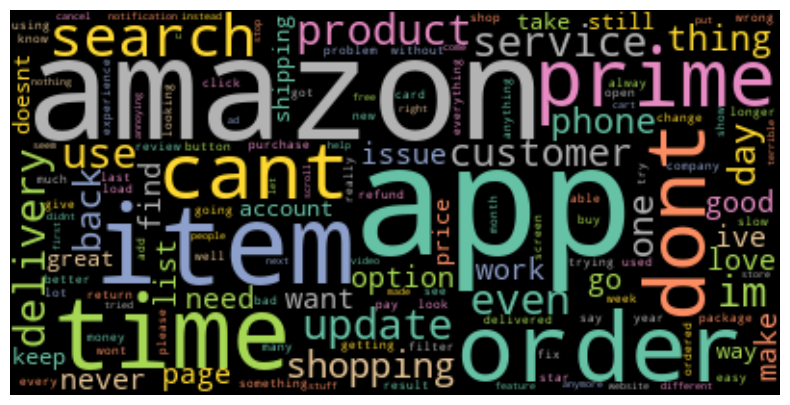

In [9]:
review_txt = " ".join(i for i in df['content'][:10000])

#### wordcloud to visulize most frequent words
plt.figure(figsize=(10,5))
wc = WordCloud(colormap='Set2',collocations=False).generate(review_txt)
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show()


In [10]:
### textblob to count most frequent words in text data for amazon reviews

blob = TextBlob(review_txt)
top_50_most_common_words = FreqDist(blob.words).most_common(50)
print(f"Top 50 Most Common Words in Amazon Review Data: {top_50_most_common_words}")




Top 50 Most Common Words in Amazon Review Data: [('app', 6701), ('amazon', 5927), ('item', 3040), ('time', 2501), ('get', 2297), ('order', 2293), ('dont', 1646), ('prime', 1619), ('cant', 1511), ('search', 1501), ('product', 1491), ('even', 1456), ('update', 1445), ('like', 1432), ('service', 1412), ('im', 1410), ('delivery', 1405), ('use', 1367), ('customer', 1325), ('shopping', 1300), ('day', 1297), ('back', 1259), ('one', 1214), ('thing', 1105), ('phone', 1068), ('option', 1067), ('make', 1061), ('need', 1056), ('go', 1027), ('want', 1022), ('ive', 1016), ('good', 976), ('work', 971), ('issue', 967), ('page', 961), ('never', 949), ('would', 924), ('love', 902), ('find', 901), ('list', 895), ('great', 892), ('price', 892), ('account', 877), ('way', 860), ('shipping', 859), ('still', 854), ('also', 848), ('keep', 821), ('take', 787), ('doesnt', 781)]


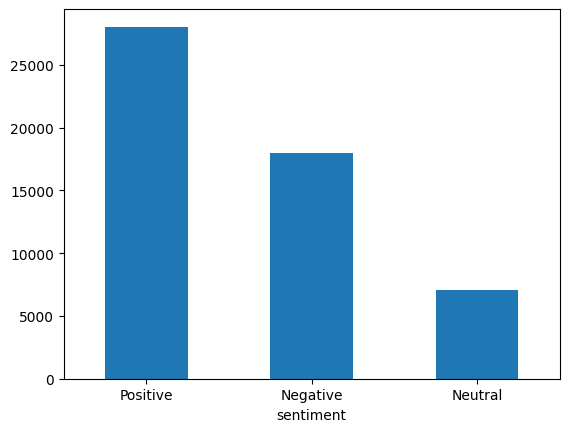

In [11]:
## user-defined function for polarity score




def polarity(text):
    return TextBlob(text).polarity

df['polarity'] = df['content'].apply(polarity)



#user-defined function for polarity score

def sentiment(label):
    if label <0:
        return "Negative"
    elif label == 0:
        return "Neutral"
    elif label > 0:
        return "Positive"

df['sentiment'] = df['polarity'].apply(sentiment)


df['sentiment'].value_counts().plot(kind='bar',rot=0)

plt.show()

In [12]:
#using tensorflow to tokenize the text data to be ran through a Bidirectionlal LSTM

X = df['content']
y = df['sentiment']
y = LabelEncoder().fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.15, random_state=1)




num_words = 20000
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print("length of word index",len(word_index))

length of word index 28511


In [13]:
### padding X_train and X_test and determing max_length

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


max_length = 0
for sequence in X_train:
    sequence_length = len(sequence)
    if sequence_length > max_length:
        max_length = sequence_length

print("Max Length of Sequences: ",max_length)

Max Length of Sequences:  146


In [14]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

X_train = pad_sequences(X_train,padding='post')
X_test = pad_sequences(X_test,padding="post")





RNN = Sequential()
RNN.add(Embedding(len(word_index)+1,output_dim=200,input_length=max_length))
RNN.add(SpatialDropout1D(0.3))
RNN.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
RNN.add(Dropout(0.2))
RNN.add(Dense(150,activation='relu'))
RNN.add(Dropout(0.1))
RNN.add(Dense(3,activation='softmax'))
RNN.summary()



RNN.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = RNN.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.1)
loss,acc = RNN.evaluate(X_test,y_test)
y_pred = RNN.predict(X_test)

print(f"Testing Loss: {loss:.2f}")
print(f"Testing Accuracy: {acc*100:.2f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 106s 81ms/step - accuracy: 0.7677 - loss: 0.5438 - val_accuracy: 0.9158 - val_loss: 0.2266
Epoch 2/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 103s 81ms/step - accuracy: 0.9486 - loss: 0.1565 - val_accuracy: 0.9408 - val_loss: 0.1733
Epoch 3/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 103s 81ms/step - accuracy: 0.9666 - loss: 0.1059 - val_accuracy: 0.9364 - val_loss: 0.1826
Epoch 4/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 109s 86ms/step - accuracy: 0.9727 - loss: 0.0838 - val_accuracy: 0.9370 - val_loss: 0.1861
Epoch 5/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 111s 87ms/step - accuracy: 0.9804 - loss: 0.0604 - val_accuracy: 0.9359 - val_loss: 0.2071
Epoch 6/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 110s 87ms/step - accuracy: 0.9858 - loss: 0.0470 - val_accuracy: 0.9353 - val_loss: 0.2418
Epoch 7/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 113s 89ms/step - accuracy: 0.9876 - loss: 0.0387 - val_accuracy: 0.9284 - val_loss: 0.2735
Epoch 8/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 110s 87ms/step - accuracy: 

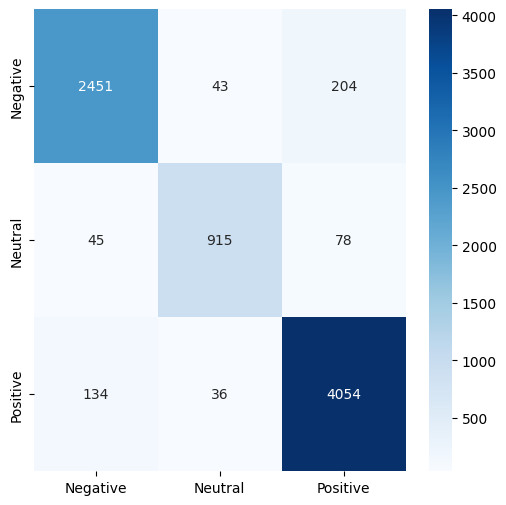

In [16]:
### confusion matrix and classification report


y_true = np.argmax(y_test,axis=1)
y_pred = np.argmax(y_pred,axis=1)


conf_matrix = confusion_matrix(y_true,y_pred)


plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
plt.show()

In [17]:
print(classification_report(y_true,y_pred,target_names=['Negative','Neutral','Positive']))


              precision    recall  f1-score   support

    Negative       0.93      0.91      0.92      2698
     Neutral       0.92      0.88      0.90      1038
    Positive       0.93      0.96      0.95      4224

    accuracy                           0.93      7960
   macro avg       0.93      0.92      0.92      7960
weighted avg       0.93      0.93      0.93      7960

